In [1]:
import random
import time
from itertools import product, islice
from collections import defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

import torch
import torch.nn as nn

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
torch.set_default_dtype(torch.float64)
device

'cuda:0'

In [3]:
def get_func(model: nn.Module, loss_fn, x, y):
    def func(*p_tensors):
        assert len(list(model.parameters())) == len(p_tensors)
        assert type(model) is nn.Sequential
        i = 0
        z = x
        for module in model:
            if type(module) is nn.Linear:
                if module.bias is None:
                    z = nn.functional.linear(z, p_tensors[i], None)
                    i += 1
                else:
                    z = nn.functional.linear(z, p_tensors[i], p_tensors[i+1])
                    i += 2
            if type(module) in [nn.Tanh, nn.Sigmoid, nn.ReLU]:
                z = module(z)
        return loss_fn(z, y)
    return func

def hessian_autograd(model, loss_fn, x, y):
    H = torch.autograd.functional.hessian(get_func(model, loss_fn, x, y), tuple(model.parameters()))
    return H

def hvp_autograd(model, v, loss_fn, x, y):
    _, Hv = torch.autograd.functional.hvp(get_func(model, loss_fn, x, y), tuple(model.parameters()), v)
    return Hv

def decompose_hessian(hessian, lengths, shapes):
    H_matrix = torch.zeros(sum(lenghts), sum(lenghts))
    for i, j in product(range(len(shapes)), range(len(shapes))):
        i0, i1 = sum(lenghts[:i+1]) - lenghts[i], sum(lenghts[:i+1])
        j0, j1 = sum(lenghts[:j+1]) - lenghts[j], sum(lenghts[:j+1])
        H_matrix[i0:i1, j0:j1] = hessian[i][j].reshape(lenghts[i], lenghts[j])
    vals, vecs = torch.linalg.eigh(H_matrix)
    vs = []
    for i in range(sum(lenghts)):
        vec = vecs[:, i]
        v = tuple(vec[sum(lenghts[:i]):sum(lenghts[:i+1])].reshape(shapes[i]) for i in range(len(lenghts)))
        vs.append(v)
    return vals, vs

In [4]:
rmse_loss_fn_torch = lambda x, y: torch.sqrt(torch.mean(torch.pow(x-y, 2)))
qmqe_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 4)), 1/4)
smse_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 6)), 1/6)
mse_loss_fn_torch = nn.MSELoss()

def lp_norm(p):
    def loss(x, y):
        return torch.pow(torch.mean(torch.pow(torch.abs(x-y), p)), 1/p)
    return loss

def dl_loss(epsilon):
    def loss(x, y):
        return torch.mean(0.5 * torch.log2(1 + torch.pow((x-y) / epsilon, 2)))
    return loss

In [5]:
def loss(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    return loss_fn(mlp(x.to(device)), y).detach().cpu().numpy()

def gradient(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    loss_fn(mlp(x.to(device)), y).backward()
    grads = []
    for param in mlp.parameters():
        grads.append(param.grad.detach().clone().cpu().numpy().flatten())
        param.grad = None
    mlp.zero_grad()
    return np.concatenate(grads)

In [6]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

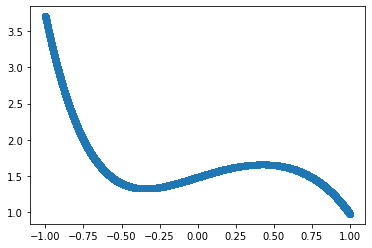

In [9]:
plt.scatter(x_i.cpu(), y_i.cpu())

In [10]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [11]:
result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, mse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = mse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
mlp.zero_grad()

         Current function value: 0.000000
         Iterations: 6665
         Function evaluations: 7737
         Gradient evaluations: 7725
1.0930673575791284e-12


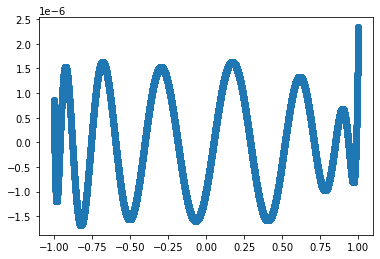

In [14]:
with torch.no_grad():
    plt.scatter(x_i.cpu(), y_i.cpu() - mlp(x_i).cpu())

In [17]:
with torch.no_grad():
    c = 1 / torch.mean(torch.abs(y_i - mlp(x_i))).item()
    yd_i = c * (y_i - mlp(x_i))

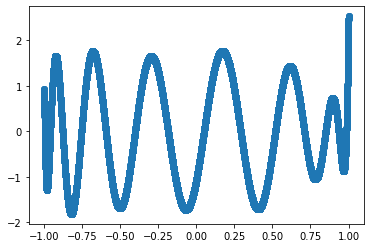

In [19]:
plt.scatter(x_i.cpu(), yd_i.cpu())

In [27]:
width = 20
mlp2 = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp2.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [28]:
result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp2, mse_loss_fn_torch, x_i, yd_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp2.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = mse_loss_fn_torch(mlp2(x_i), yd_i).item()
print(l)
mlp2.zero_grad()

         Current function value: 0.000000
         Iterations: 24856
         Function evaluations: 26156
         Gradient evaluations: 26144
3.3707178435879613e-09


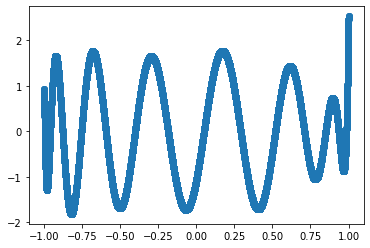

In [26]:
with torch.no_grad():
#     plt.scatter(x_i.cpu(), yd_i.cpu())
    plt.scatter(x_i.cpu(), mlp2(x_i).cpu())

In [34]:
with torch.no_grad():
    print(mse_loss_fn_torch(mlp(x_i) + (1/c)*mlp2(x_i), y_i).item())

2.8857238318518905e-21


In [35]:
with torch.no_grad():
    c2 = 1 / torch.mean(torch.abs(y_i - (mlp(x_i) + (1/c)*mlp2(x_i)))).item()
    yd2_i = c2 * (y_i - (mlp(x_i) + (1/c)*mlp2(x_i)))

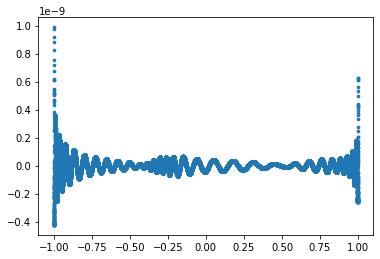

In [38]:
with torch.no_grad():
    plt.scatter(x_i.cpu(), (y_i - (mlp(x_i) + (1/c)*mlp2(x_i))).cpu(), s=7)

In [39]:
width = 20
mlp3 = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp3.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

In [40]:
result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp3, mse_loss_fn_torch, x_i, yd2_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp3.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = mse_loss_fn_torch(mlp3(x_i), yd2_i).item()
print(l)
mlp3.zero_grad()

         Current function value: 1.790141
         Iterations: 24061
         Function evaluations: 25196
         Gradient evaluations: 25184
1.790141477914346


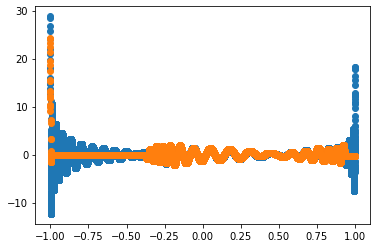

In [44]:
with torch.no_grad():
    plt.scatter(x_i.cpu(), yd2_i.cpu())
    plt.scatter(x_i.cpu(), mlp3(x_i).cpu())

In [45]:
with torch.no_grad():
    print(mse_loss_fn_torch(mlp(x_i) + (1/c)*mlp2(x_i) + (1/c2)*mlp3(x_i), y_i).item())

2.1022000653311976e-21


### Let's compare a width 20 network performance to a 10 + 10 (boosted) ensemble performance

In [51]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

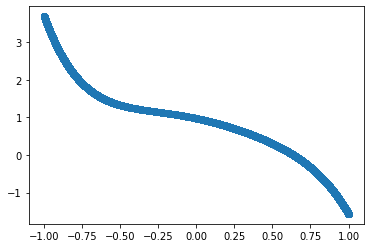

In [52]:
plt.scatter(x_i.cpu(), y_i.cpu())

In [53]:
# width-20 network

width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, mse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = mse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
mlp.zero_grad()

         Current function value: 0.000000
         Iterations: 9670
         Function evaluations: 10953
         Gradient evaluations: 10943
5.835053349765892e-13


In [58]:
# 10 + 10

width = 10
f1 = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params1 = []
shapes1 = []
lengths1 = []
for param in f1.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes1.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lengths1.append(len(param_np_flat))
    params1.append(param_np_flat)

param_vector1 = np.concatenate(params1)

result = optimize.minimize(loss,
                       param_vector1, 
                       args=(lengths1, shapes1, f1, mse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(f1.parameters()):
    param_data = result.x[l:l+lengths1[j]]
    l += lengths1[j]
    param_data_shaped = param_data.reshape(shapes1[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = mse_loss_fn_torch(f1(x_i), y_i).item()
print(l)
f1.zero_grad()


with torch.no_grad():
    c1 = 1 / torch.mean(torch.abs(y_i - f1(x_i))).item()
    yd1_i = c1 * (y_i - f1(x_i))


width = 10
f2 = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params2 = []
shapes2 = []
lengths2 = []
for param in f2.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes2.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lengths2.append(len(param_np_flat))
    params2.append(param_np_flat)

param_vector2 = np.concatenate(params1)



result = optimize.minimize(loss,
                       param_vector2, 
                       args=(lengths2, shapes2, f2, mse_loss_fn_torch, x_i, yd1_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(f2.parameters()):
    param_data = result.x[l:l+lengths2[j]]
    l += lengths2[j]
    param_data_shaped = param_data.reshape(shapes2[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = mse_loss_fn_torch(f2(x_i), yd1_i).item()
print(l)
f2.zero_grad()


with torch.no_grad():
    print("Boosted loss: {}".format(mse_loss_fn_torch(f1(x_i) + (1/c1)*f2(x_i), y_i).item()))

         Current function value: 0.000000
         Iterations: 5413
         Function evaluations: 6212
         Gradient evaluations: 6201
1.5876431675881177e-12
         Current function value: 0.000001
         Iterations: 6463
         Function evaluations: 6908
         Gradient evaluations: 6896
1.1288874097005012e-06
Boosted loss: 1.2372960325165759e-18


## Let's look at scaling laws and consistency between runs

In [67]:
widths = [4, 6, 8, 10, 12, 16, 18, 20, 22, 24]
repeats = 10

results = defaultdict(list)

for width in tqdm(widths):
    for _ in tqdm(range(repeats), leave=False):

        mlp = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, 1)
        ).to(device)

        params = []
        shapes = []
        lenghts = []
        for param in mlp.parameters():
            param_np = param.data.detach().clone().cpu().numpy()
            shapes.append(param_np.shape)
            param_np_flat = param_np.flatten()
            lenghts.append(len(param_np_flat))
            params.append(param_np_flat)

        param_vector = np.concatenate(params)

        result = optimize.minimize(loss,
                               param_vector, 
                               args=(lenghts, shapes, mlp, mse_loss_fn_torch, x_i, y_i, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-40,
                                   'maxiter': 25000,
        #                                'finite_diff_rel_step': 1e-15
                               },
                            )

        l = 0
        for j, param in enumerate(mlp.parameters()):
            param_data = result.x[l:l+lenghts[j]]
            l += lenghts[j]
            param_data_shaped = param_data.reshape(shapes[j])
            param.data = torch.tensor(param_data_shaped).to(device)

        results[width].append(mse_loss_fn_torch(mlp(x_i), y_i).item())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 5138
         Function evaluations: 5775
         Gradient evaluations: 5763
         Current function value: 0.000000
         Iterations: 14273
         Function evaluations: 16170
         Gradient evaluations: 16158
         Current function value: 0.000000
         Iterations: 3015
         Function evaluations: 3492
         Gradient evaluations: 3480
         Current function value: 0.000000
         Iterations: 2234
         Function evaluations: 2593
         Gradient evaluations: 2581
         Current function value: 0.000000
         Iterations: 6743
         Function evaluations: 7624
         Gradient evaluations: 7614
         Current function value: 0.000000
         Iterations: 1750
         Function evaluations: 2037
         Gradient evaluations: 2025
         Current function value: 0.000000
         Iterations: 10954
         Function evaluations: 12463
         Gradient evaluations: 12451
         Curre

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 7090
         Function evaluations: 8034
         Gradient evaluations: 8022
         Current function value: 0.000000
         Iterations: 4574
         Function evaluations: 5215
         Gradient evaluations: 5203
         Current function value: 0.000000
         Iterations: 7809
         Function evaluations: 8767
         Gradient evaluations: 8757
         Current function value: 0.000000
         Iterations: 10876
         Function evaluations: 12364
         Gradient evaluations: 12352
         Current function value: 0.000000
         Iterations: 9851
         Function evaluations: 11202
         Gradient evaluations: 11191
         Current function value: 0.000000
         Iterations: 16510
         Function evaluations: 18767
         Gradient evaluations: 18755
         Current function value: 0.000000
         Iterations: 4782
         Function evaluations: 5422
         Gradient evaluations: 5410
         Cur

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 9348
         Function evaluations: 10488
         Gradient evaluations: 10478
         Current function value: 0.000000
         Iterations: 4651
         Function evaluations: 5262
         Gradient evaluations: 5251
         Current function value: 0.000000
         Iterations: 6652
         Function evaluations: 7638
         Gradient evaluations: 7626
         Current function value: 0.000000
         Iterations: 7893
         Function evaluations: 9041
         Gradient evaluations: 9029
         Current function value: 0.000000
         Iterations: 7751
         Function evaluations: 8715
         Gradient evaluations: 8707
         Current function value: 0.000000
         Iterations: 16003
         Function evaluations: 17968
         Gradient evaluations: 17956
         Current function value: 0.000000
         Iterations: 12417
         Function evaluations: 14084
         Gradient evaluations: 14073
         Cur

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 10310
         Function evaluations: 11728
         Gradient evaluations: 11716
         Current function value: 0.000000
         Iterations: 4453
         Function evaluations: 5059
         Gradient evaluations: 5049
         Current function value: 0.000000
         Iterations: 6152
         Function evaluations: 6970
         Gradient evaluations: 6961
         Current function value: 0.000000
         Iterations: 5637
         Function evaluations: 6452
         Gradient evaluations: 6442
         Current function value: 0.000000
         Iterations: 8747
         Function evaluations: 9946
         Gradient evaluations: 9934
         Current function value: 0.000000
         Iterations: 9992
         Function evaluations: 11433
         Gradient evaluations: 11421
         Current function value: 0.000000
         Iterations: 8042
         Function evaluations: 9210
         Gradient evaluations: 9199
         Curren

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8258
         Function evaluations: 9325
         Gradient evaluations: 9313
         Current function value: 0.000000
         Iterations: 12721
         Function evaluations: 14499
         Gradient evaluations: 14487
         Current function value: 0.000000
         Iterations: 9693
         Function evaluations: 10981
         Gradient evaluations: 10971
         Current function value: 0.000000
         Iterations: 4539
         Function evaluations: 5162
         Gradient evaluations: 5150
         Current function value: 0.000000
         Iterations: 13978
         Function evaluations: 15815
         Gradient evaluations: 15803
         Current function value: 0.000000
         Iterations: 8581
         Function evaluations: 9804
         Gradient evaluations: 9796
         Current function value: 0.000000
         Iterations: 7519
         Function evaluations: 8518
         Gradient evaluations: 8508
         Cur

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8370
         Function evaluations: 9651
         Gradient evaluations: 9640
         Current function value: 0.000000
         Iterations: 10093
         Function evaluations: 11540
         Gradient evaluations: 11532
         Current function value: 0.000000
         Iterations: 4185
         Function evaluations: 4734
         Gradient evaluations: 4722
         Current function value: 0.000000
         Iterations: 9805
         Function evaluations: 11095
         Gradient evaluations: 11083
         Current function value: 0.000000
         Iterations: 7281
         Function evaluations: 8261
         Gradient evaluations: 8249
         Current function value: 0.000000
         Iterations: 5519
         Function evaluations: 6220
         Gradient evaluations: 6209
         Current function value: 0.000000
         Iterations: 4485
         Function evaluations: 5076
         Gradient evaluations: 5066
         Curren

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 7287
         Function evaluations: 8306
         Gradient evaluations: 8296
         Current function value: 0.000000
         Iterations: 7835
         Function evaluations: 9042
         Gradient evaluations: 9030
         Current function value: 0.000000
         Iterations: 6452
         Function evaluations: 7260
         Gradient evaluations: 7248
         Current function value: 0.000000
         Iterations: 6850
         Function evaluations: 7760
         Gradient evaluations: 7752
         Current function value: 0.000000
         Iterations: 8672
         Function evaluations: 9825
         Gradient evaluations: 9813
         Current function value: 0.000000
         Iterations: 14364
         Function evaluations: 16424
         Gradient evaluations: 16412
         Current function value: 0.000000
         Iterations: 3007
         Function evaluations: 3359
         Gradient evaluations: 3347
         Current 

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 6819
         Function evaluations: 7750
         Gradient evaluations: 7738
         Current function value: 0.000000
         Iterations: 16201
         Function evaluations: 18617
         Gradient evaluations: 18605
         Current function value: 0.000000
         Iterations: 7941
         Function evaluations: 9186
         Gradient evaluations: 9174
         Current function value: 0.000000
         Iterations: 3635
         Function evaluations: 4170
         Gradient evaluations: 4158
         Current function value: 0.000000
         Iterations: 4203
         Function evaluations: 4732
         Gradient evaluations: 4720
         Current function value: 0.000000
         Iterations: 10227
         Function evaluations: 11684
         Gradient evaluations: 11672
         Current function value: 0.000000
         Iterations: 3586
         Function evaluations: 4062
         Gradient evaluations: 4050
         Curre

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 12826
         Function evaluations: 14681
         Gradient evaluations: 14674
         Current function value: 0.000000
         Iterations: 5070
         Function evaluations: 5733
         Gradient evaluations: 5721
         Current function value: 0.000000
         Iterations: 11346
         Function evaluations: 12915
         Gradient evaluations: 12903
         Current function value: 0.000000
         Iterations: 8350
         Function evaluations: 9552
         Gradient evaluations: 9540
         Current function value: 0.000000
         Iterations: 9805
         Function evaluations: 11149
         Gradient evaluations: 11138
         Current function value: 0.000000
         Iterations: 5479
         Function evaluations: 6267
         Gradient evaluations: 6256
         Current function value: 0.000000
         Iterations: 6238
         Function evaluations: 7189
         Gradient evaluations: 7178
         Cur

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8887
         Function evaluations: 10055
         Gradient evaluations: 10043
         Current function value: 0.000000
         Iterations: 9515
         Function evaluations: 10812
         Gradient evaluations: 10800
         Current function value: 0.000000
         Iterations: 19857
         Function evaluations: 22741
         Gradient evaluations: 22729
         Current function value: 0.000000
         Iterations: 6851
         Function evaluations: 7853
         Gradient evaluations: 7842
         Current function value: 0.000000
         Iterations: 5581
         Function evaluations: 6336
         Gradient evaluations: 6324
         Current function value: 0.000000
         Iterations: 15519
         Function evaluations: 17813
         Gradient evaluations: 17801
         Current function value: 0.000000
         Iterations: 6318
         Function evaluations: 7177
         Gradient evaluations: 7165
         C

Text(0.5, 1.0, 'Pure BFGS training (unboosted)')

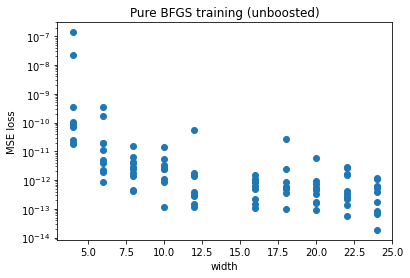

In [70]:
for width in widths:
    plt.scatter([width]*repeats, results[width], color='C0')
plt.yscale('log')
plt.ylabel("MSE loss")
# plt.xscale('log')
plt.xlabel("width")
plt.title("Pure BFGS training (unboosted)")

Text(0.5, 1.0, 'Pure BFGS training')

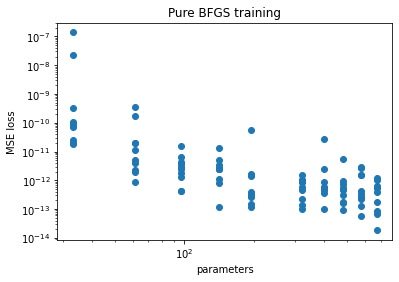

In [82]:
for width in widths:
    n_params = (1 * width + width) + (width * width + width) + (width * 1 + 1)
    plt.scatter([n_params]*repeats, results[width], color='C0')
plt.yscale('log')
plt.ylabel("MSE loss")
plt.xscale('log')
plt.xlabel("parameters")
plt.title("Pure BFGS training")

### Now for boosted version

In [74]:
widths = [4, 6, 8, 10, 12, 16, 18, 20, 22, 24]
repeats = 10

results_boosted = defaultdict(list)

for width in tqdm(widths):
    for _ in tqdm(range(repeats), leave=False):

        f1 = nn.Sequential(
            nn.Linear(1, int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), 1)
        ).to(device)

        params1 = []
        shapes1 = []
        lengths1 = []
        for param in f1.parameters():
            param_np = param.data.detach().clone().cpu().numpy()
            shapes1.append(param_np.shape)
            param_np_flat = param_np.flatten()
            lengths1.append(len(param_np_flat))
            params1.append(param_np_flat)

        param_vector1 = np.concatenate(params1)

        result = optimize.minimize(loss,
                               param_vector1, 
                               args=(lengths1, shapes1, f1, mse_loss_fn_torch, x_i, y_i, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-40,
                                   'maxiter': 25000,
        #                                'finite_diff_rel_step': 1e-15
                               },
                            )

        l = 0
        for j, param in enumerate(f1.parameters()):
            param_data = result.x[l:l+lengths1[j]]
            l += lengths1[j]
            param_data_shaped = param_data.reshape(shapes1[j])
            param.data = torch.tensor(param_data_shaped).to(device)

#         l = mse_loss_fn_torch(f1(x_i), y_i).item()
#         print(l)
#         f1.zero_grad()


        with torch.no_grad():
            c1 = 1 / torch.mean(torch.abs(y_i - f1(x_i))).item()
            yd1_i = c1 * (y_i - f1(x_i))


        f2 = nn.Sequential(
            nn.Linear(1, int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), 1)
        ).to(device)

        params2 = []
        shapes2 = []
        lengths2 = []
        for param in f2.parameters():
            param_np = param.data.detach().clone().cpu().numpy()
            shapes2.append(param_np.shape)
            param_np_flat = param_np.flatten()
            lengths2.append(len(param_np_flat))
            params2.append(param_np_flat)

        param_vector2 = np.concatenate(params1)


        result = optimize.minimize(loss,
                               param_vector2, 
                               args=(lengths2, shapes2, f2, mse_loss_fn_torch, x_i, yd1_i, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-40,
                                   'maxiter': 25000,
        #                                'finite_diff_rel_step': 1e-15
                               },
                            )

        l = 0
        for j, param in enumerate(f2.parameters()):
            param_data = result.x[l:l+lengths2[j]]
            l += lengths2[j]
            param_data_shaped = param_data.reshape(shapes2[j])
            param.data = torch.tensor(param_data_shaped).to(device)

#         l = mse_loss_fn_torch(f2(x_i), yd1_i).item()
#         print(l)
#         f2.zero_grad()

        with torch.no_grad():
            results_boosted[width].append(mse_loss_fn_torch(f1(x_i) + (1/c1)*f2(x_i), y_i).item())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000001
         Iterations: 4093
         Function evaluations: 4800
         Gradient evaluations: 4788
         Current function value: 1.101032
         Iterations: 1193
         Function evaluations: 1465
         Gradient evaluations: 1453
         Current function value: 0.008906
         Iterations: 451
         Function evaluations: 592
         Gradient evaluations: 580
         Current function value: 0.165407
         Iterations: 528
         Function evaluations: 612
         Gradient evaluations: 600
         Current function value: 0.000001
         Iterations: 2124
         Function evaluations: 2433
         Gradient evaluations: 2421
         Current function value: 0.448780
         Iterations: 2347
         Function evaluations: 2767
         Gradient evaluations: 2755
         Current function value: 0.000336
         Iterations: 994
         Function evaluations: 1212
         Gradient evaluations: 1200
         Current function v

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8272
         Function evaluations: 9553
         Gradient evaluations: 9541
         Current function value: 0.925330
         Iterations: 603
         Function evaluations: 684
         Gradient evaluations: 672
         Current function value: 0.000000
         Iterations: 18690
         Function evaluations: 21289
         Gradient evaluations: 21278
         Current function value: 0.485651
         Iterations: 879
         Function evaluations: 1040
         Gradient evaluations: 1028
         Current function value: 0.000040
         Iterations: 2527
         Function evaluations: 2951
         Gradient evaluations: 2939
         Current function value: 0.093999
         Iterations: 2508
         Function evaluations: 2763
         Gradient evaluations: 2751
         Current function value: 0.000000
         Iterations: 8563
         Function evaluations: 9837
         Gradient evaluations: 9825
         Current func

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 7547
         Function evaluations: 8545
         Gradient evaluations: 8533
         Current function value: 0.071011
         Iterations: 3774
         Function evaluations: 4156
         Gradient evaluations: 4144
         Current function value: 0.000000
         Iterations: 7359
         Function evaluations: 8387
         Gradient evaluations: 8380
         Current function value: 0.001540
         Iterations: 3460
         Function evaluations: 3825
         Gradient evaluations: 3813
         Current function value: 0.000000
         Iterations: 12057
         Function evaluations: 13826
         Gradient evaluations: 13815
         Current function value: 0.211128
         Iterations: 3112
         Function evaluations: 3446
         Gradient evaluations: 3434
         Current function value: 0.000000
         Iterations: 18568
         Function evaluations: 21330
         Gradient evaluations: 21318
         Curre

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 3614
         Function evaluations: 4150
         Gradient evaluations: 4138
         Current function value: 0.036797
         Iterations: 2536
         Function evaluations: 2784
         Gradient evaluations: 2772
         Current function value: 0.000000
         Iterations: 9102
         Function evaluations: 10467
         Gradient evaluations: 10455
         Current function value: 0.785425
         Iterations: 2559
         Function evaluations: 2853
         Gradient evaluations: 2841
         Current function value: 0.000000
         Iterations: 10303
         Function evaluations: 11816
         Gradient evaluations: 11804
         Current function value: 0.256869
         Iterations: 4999
         Function evaluations: 5415
         Gradient evaluations: 5403
         Current function value: 0.000000
         Iterations: 4314
         Function evaluations: 4870
         Gradient evaluations: 4858
         Curren

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8089
         Function evaluations: 9189
         Gradient evaluations: 9178
         Current function value: 0.000560
         Iterations: 8052
         Function evaluations: 8813
         Gradient evaluations: 8801
         Current function value: 0.000000
         Iterations: 5381
         Function evaluations: 6120
         Gradient evaluations: 6108
         Current function value: 0.000009
         Iterations: 7004
         Function evaluations: 7535
         Gradient evaluations: 7523
         Current function value: 0.000000
         Iterations: 5969
         Function evaluations: 6745
         Gradient evaluations: 6734
         Current function value: 1.565029
         Iterations: 82
         Function evaluations: 91
         Gradient evaluations: 91
         Current function value: 0.000000
         Iterations: 7153
         Function evaluations: 8188
         Gradient evaluations: 8177
         Current function 

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 13616
         Function evaluations: 15323
         Gradient evaluations: 15312
         Current function value: 0.069132
         Iterations: 8817
         Function evaluations: 9463
         Gradient evaluations: 9451
         Current function value: 0.000000
         Iterations: 8666
         Function evaluations: 9865
         Gradient evaluations: 9856
         Current function value: 0.000001
         Iterations: 11577
         Function evaluations: 12324
         Gradient evaluations: 12312
         Current function value: 0.000000
         Iterations: 8276
         Function evaluations: 9343
         Gradient evaluations: 9332
         Current function value: 0.169954
         Iterations: 10823
         Function evaluations: 11511
         Gradient evaluations: 11499
         Current function value: 0.000000
         Iterations: 9392
         Function evaluations: 10844
         Gradient evaluations: 10832
         

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8173
         Function evaluations: 9290
         Gradient evaluations: 9278
         Current function value: 0.220179
         Iterations: 13653
         Function evaluations: 14586
         Gradient evaluations: 14574
         Current function value: 0.000000
         Iterations: 7966
         Function evaluations: 9047
         Gradient evaluations: 9035
         Current function value: 0.797702
         Iterations: 25000
         Function evaluations: 26391
         Gradient evaluations: 26391
         Current function value: 0.000000
         Iterations: 4392
         Function evaluations: 4921
         Gradient evaluations: 4910
         Current function value: 0.000001
         Iterations: 5672
         Function evaluations: 6090
         Gradient evaluations: 6078
         Current function value: 0.000000
         Iterations: 7054
         Function evaluations: 7981
         Gradient evaluations: 7969
         Curre

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 6399
         Function evaluations: 7382
         Gradient evaluations: 7370
         Current function value: 0.235806
         Iterations: 19672
         Function evaluations: 20841
         Gradient evaluations: 20829
         Current function value: 0.000000
         Iterations: 8537
         Function evaluations: 9820
         Gradient evaluations: 9809
         Current function value: 0.000000
         Iterations: 9585
         Function evaluations: 10169
         Gradient evaluations: 10157
         Current function value: 0.000000
         Iterations: 4236
         Function evaluations: 4761
         Gradient evaluations: 4750
         Current function value: 0.000000
         Iterations: 18237
         Function evaluations: 19288
         Gradient evaluations: 19276
         Current function value: 0.000000
         Iterations: 8004
         Function evaluations: 9151
         Gradient evaluations: 9139
         Cur

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8257
         Function evaluations: 9419
         Gradient evaluations: 9408
         Current function value: 0.000000
         Iterations: 18993
         Function evaluations: 20100
         Gradient evaluations: 20088
         Current function value: 0.000000
         Iterations: 11568
         Function evaluations: 13115
         Gradient evaluations: 13106
         Current function value: 0.000000
         Iterations: 17829
         Function evaluations: 18932
         Gradient evaluations: 18921
         Current function value: 0.000000
         Iterations: 7892
         Function evaluations: 8917
         Gradient evaluations: 8905
         Current function value: 0.000004
         Iterations: 7265
         Function evaluations: 7751
         Gradient evaluations: 7739
         Current function value: 0.000000
         Iterations: 9290
         Function evaluations: 10522
         Gradient evaluations: 10511
         

Text(0.5, 1.0, 'Pure BFGS training with error-learning (half and half)')

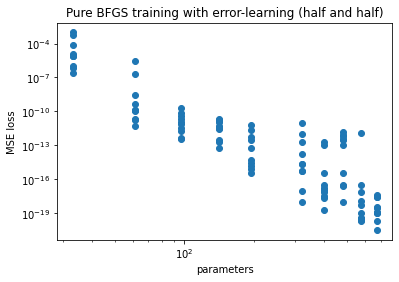

In [81]:
for width in widths:
    n_params = (1 * width + width) + (width * width + width) + (width * 1 + 1)
    plt.scatter([n_params]*repeats, results_boosted[width], color='C0')
plt.yscale('log')
plt.ylabel("MSE loss")
plt.xscale('log')
plt.xlabel("parameters")
plt.title("Pure BFGS training with error-learning (half and half)")

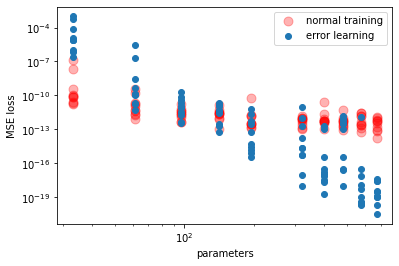

In [91]:
for i, width in enumerate(widths):
    label1 = "normal training" if i == 0 else None
    label2 = "error learning" if i == 0 else None
    n_params = (1 * width + width) + (width * width + width) + (width * 1 + 1)
    plt.scatter([n_params]*repeats, results[width], color='red', alpha=0.3, label=label1, s=80)
    plt.scatter([n_params]*repeats, results_boosted[width], color='C0', label=label2)
plt.yscale('log')
plt.ylabel("MSE loss")
plt.xscale('log')
plt.xlabel("parameters")
plt.legend()

In [92]:
with torch.no_grad():
    print(mse_loss_fn_torch(f1(x_i) + (1/c1)*f2(x_i), y_i).item())

2.8700470225002928e-18


In [94]:
squishedf = nn.Sequential(
    nn.Linear(1, int(width)),
    nn.Tanh(),
    nn.Linear(int(width), int(width)),
    nn.Tanh(),
    nn.Linear(int(width), 1)
).to(device)

In [192]:
with torch.no_grad():
    for p in squishedf.parameters():
        p.data = torch.zeros(p.shape).to(device)

with torch.no_grad():
    squishedf[0].bias[0:12] = f1[0].bias
    squishedf[0].bias[12:] = f2[0].bias
    
    squishedf[2].bias[0:12] = f1[2].bias
    squishedf[2].bias[12:] = f2[2].bias
    
    squishedf[4].bias[0] = f1[4].bias + (1/c1)*f2[4].bias
#     squishedf[4].bias[0] = f1[4].bias
#     squishedf[4].bias[0] = f2[4].bias

with torch.no_grad():
    squishedf[0].weight[0:12, :] = f1[0].weight
    squishedf[0].weight[12:24, :] = f2[0].weight
    
    squishedf[2].weight[0:12, 0:12] = f1[2].weight
    squishedf[2].weight[12:24, 12:24] = f2[2].weight
    
    squishedf[4].weight[:, 0:12] = f1[4].weight
    squishedf[4].weight[:, 12:24] = (1/c1)*f2[4].weight
#     squishedf[4].weight[:, 12:24] = torch.zeros((1, 12)).to(device)
#     squishedf[4].weight[:, 12:24] = f2[4].weight


In [194]:
with torch.no_grad():
    print(mse_loss_fn_torch(squishedf(x_i), y_i).item())

2.870047031317198e-18


In [197]:
params = []
shapes = []
lengths = []
for param in squishedf.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lengths.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)


result = optimize.minimize(loss,
                       param_vector, 
                       args=(lengths, shapes, squishedf, mse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(squishedf.parameters()):
    param_data = result.x[l:l+lengths[j]]
    l += lengths[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

         Current function value: 0.000000
         Iterations: 8307
         Function evaluations: 9218
         Gradient evaluations: 9206


In [198]:
with torch.no_grad():
    print(mse_loss_fn_torch(squishedf(x_i), y_i).item())

3.000981923205073e-11


#### hahaha okay so training the merged network fails miserably. maybe some quirk of BFGS's initial steps? Maybe BFGS doesn't work well if you started it from the minimum? But this would contradict some earlier experiments.... weird.

In [200]:
widths = [28, 30, 32, 34, 36, 38, 40]
repeats = 10

results_boosted2 = defaultdict(list)

for width in tqdm(widths):
    for _ in tqdm(range(repeats), leave=False):

        f1 = nn.Sequential(
            nn.Linear(1, int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), 1)
        ).to(device)

        params1 = []
        shapes1 = []
        lengths1 = []
        for param in f1.parameters():
            param_np = param.data.detach().clone().cpu().numpy()
            shapes1.append(param_np.shape)
            param_np_flat = param_np.flatten()
            lengths1.append(len(param_np_flat))
            params1.append(param_np_flat)

        param_vector1 = np.concatenate(params1)

        result = optimize.minimize(loss,
                               param_vector1, 
                               args=(lengths1, shapes1, f1, mse_loss_fn_torch, x_i, y_i, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-40,
                                   'maxiter': 25000,
        #                                'finite_diff_rel_step': 1e-15
                               },
                            )

        l = 0
        for j, param in enumerate(f1.parameters()):
            param_data = result.x[l:l+lengths1[j]]
            l += lengths1[j]
            param_data_shaped = param_data.reshape(shapes1[j])
            param.data = torch.tensor(param_data_shaped).to(device)

#         l = mse_loss_fn_torch(f1(x_i), y_i).item()
#         print(l)
#         f1.zero_grad()


        with torch.no_grad():
            c1 = 1 / torch.mean(torch.abs(y_i - f1(x_i))).item()
            yd1_i = c1 * (y_i - f1(x_i))


        f2 = nn.Sequential(
            nn.Linear(1, int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), int(width/2)),
            nn.Tanh(),
            nn.Linear(int(width/2), 1)
        ).to(device)

        params2 = []
        shapes2 = []
        lengths2 = []
        for param in f2.parameters():
            param_np = param.data.detach().clone().cpu().numpy()
            shapes2.append(param_np.shape)
            param_np_flat = param_np.flatten()
            lengths2.append(len(param_np_flat))
            params2.append(param_np_flat)

        param_vector2 = np.concatenate(params1)


        result = optimize.minimize(loss,
                               param_vector2, 
                               args=(lengths2, shapes2, f2, mse_loss_fn_torch, x_i, yd1_i, device),
                               jac=gradient,
                               method='BFGS',
                               options={
                                   'disp': True,
                                   'gtol': 1e-40,
                                   'maxiter': 25000,
        #                                'finite_diff_rel_step': 1e-15
                               },
                            )

        l = 0
        for j, param in enumerate(f2.parameters()):
            param_data = result.x[l:l+lengths2[j]]
            l += lengths2[j]
            param_data_shaped = param_data.reshape(shapes2[j])
            param.data = torch.tensor(param_data_shaped).to(device)

#         l = mse_loss_fn_torch(f2(x_i), yd1_i).item()
#         print(l)
#         f2.zero_grad()

        with torch.no_grad():
            results_boosted2[width].append(mse_loss_fn_torch(f1(x_i) + (1/c1)*f2(x_i), y_i).item())

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 7144
         Function evaluations: 8095
         Gradient evaluations: 8083
         Current function value: 1.366678
         Iterations: 75
         Function evaluations: 116
         Gradient evaluations: 104
         Current function value: 0.000000
         Iterations: 12968
         Function evaluations: 14731
         Gradient evaluations: 14719
         Current function value: 1.336853
         Iterations: 313
         Function evaluations: 346
         Gradient evaluations: 346
         Current function value: 0.000000
         Iterations: 8915
         Function evaluations: 10097
         Gradient evaluations: 10086
         Current function value: 1.435321
         Iterations: 238
         Function evaluations: 278
         Gradient evaluations: 278
         Current function value: 0.000000
         Iterations: 6680
         Function evaluations: 7586
         Gradient evaluations: 7581
         Current function

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 7551
         Function evaluations: 8573
         Gradient evaluations: 8561
         Current function value: 0.000000
         Iterations: 12671
         Function evaluations: 13322
         Gradient evaluations: 13310
         Current function value: 0.000000
         Iterations: 7456
         Function evaluations: 8409
         Gradient evaluations: 8397
         Current function value: 0.000000
         Iterations: 23050
         Function evaluations: 24329
         Gradient evaluations: 24317
         Current function value: 0.000000
         Iterations: 10550
         Function evaluations: 11979
         Gradient evaluations: 11967
         Current function value: 0.000000
         Iterations: 12322
         Function evaluations: 13052
         Gradient evaluations: 13042
         Current function value: 0.000000
         Iterations: 11996
         Function evaluations: 13703
         Gradient evaluations: 13692
     

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 7378
         Function evaluations: 8370
         Gradient evaluations: 8361
         Current function value: 0.000000
         Iterations: 25000
         Function evaluations: 26194
         Gradient evaluations: 26194
         Current function value: 0.000000
         Iterations: 8045
         Function evaluations: 9139
         Gradient evaluations: 9129
         Current function value: 0.000000
         Iterations: 25000
         Function evaluations: 26173
         Gradient evaluations: 26173
         Current function value: 0.000000
         Iterations: 5813
         Function evaluations: 6602
         Gradient evaluations: 6591
         Current function value: 0.000000
         Iterations: 24325
         Function evaluations: 25546
         Gradient evaluations: 25534
         Current function value: 0.000000
         Iterations: 9816
         Function evaluations: 10966
         Gradient evaluations: 10954
         

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 10585
         Function evaluations: 12068
         Gradient evaluations: 12056
         Current function value: 0.000000
         Iterations: 11231
         Function evaluations: 11942
         Gradient evaluations: 11930
         Current function value: 0.000000
         Iterations: 5852
         Function evaluations: 6644
         Gradient evaluations: 6632
         Current function value: 0.000000
         Iterations: 13520
         Function evaluations: 14230
         Gradient evaluations: 14218
         Current function value: 0.000000
         Iterations: 8386
         Function evaluations: 9654
         Gradient evaluations: 9642
         Current function value: 0.000000
         Iterations: 16640
         Function evaluations: 17603
         Gradient evaluations: 17591
         Current function value: 0.000000
         Iterations: 7568
         Function evaluations: 8731
         Gradient evaluations: 8720
        

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 8598
         Function evaluations: 9870
         Gradient evaluations: 9858
         Current function value: 0.000000
         Iterations: 10150
         Function evaluations: 10711
         Gradient evaluations: 10699
         Current function value: 0.000000
         Iterations: 8691
         Function evaluations: 9859
         Gradient evaluations: 9847
         Current function value: 0.000000
         Iterations: 16369
         Function evaluations: 17287
         Gradient evaluations: 17275
         Current function value: 0.000000
         Iterations: 5559
         Function evaluations: 6290
         Gradient evaluations: 6278
         Current function value: 0.000000
         Iterations: 20082
         Function evaluations: 21129
         Gradient evaluations: 21117
         Current function value: 0.000000
         Iterations: 5517
         Function evaluations: 6206
         Gradient evaluations: 6194
         Cu

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 7943
         Function evaluations: 8960
         Gradient evaluations: 8948
         Current function value: 0.000000
         Iterations: 18959
         Function evaluations: 20154
         Gradient evaluations: 20143
         Current function value: 0.000000
         Iterations: 8500
         Function evaluations: 9692
         Gradient evaluations: 9681
         Current function value: 1.442500
         Iterations: 97
         Function evaluations: 105
         Gradient evaluations: 105
         Current function value: 0.000000
         Iterations: 7006
         Function evaluations: 7938
         Gradient evaluations: 7926
         Current function value: 0.000000
         Iterations: 10857
         Function evaluations: 11529
         Gradient evaluations: 11518
         Current function value: 0.000000
         Iterations: 5209
         Function evaluations: 5871
         Gradient evaluations: 5860
         Current f

  0%|          | 0/10 [00:00<?, ?it/s]

         Current function value: 0.000000
         Iterations: 4795
         Function evaluations: 5454
         Gradient evaluations: 5442
         Current function value: 0.000000
         Iterations: 15617
         Function evaluations: 16478
         Gradient evaluations: 16468
         Current function value: 0.000000
         Iterations: 9318
         Function evaluations: 10768
         Gradient evaluations: 10756
         Current function value: 0.000000
         Iterations: 25000
         Function evaluations: 26113
         Gradient evaluations: 26113
         Current function value: 0.000000
         Iterations: 15638
         Function evaluations: 17979
         Gradient evaluations: 17967
         Current function value: 0.000000
         Iterations: 15909
         Function evaluations: 16816
         Gradient evaluations: 16804
         Current function value: 0.000000
         Iterations: 4829
         Function evaluations: 5534
         Gradient evaluations: 5522
      

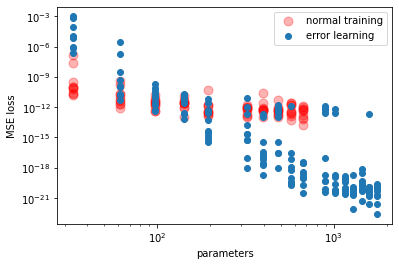

In [204]:
for i, width in enumerate([4, 6, 8, 10, 12, 16, 18, 20, 22, 24]):
    label1 = "normal training" if i == 0 else None
    n_params = (1 * width + width) + (width * width + width) + (width * 1 + 1)
    plt.scatter([n_params]*repeats, results[width], color='red', alpha=0.3, label=label1, s=80)
    
for i, width in enumerate([4, 6, 8, 10, 12, 16, 18, 20, 22, 24]):
    label2 = "error learning" if i == 0 else None
    n_params = (1 * width + width) + (width * width + width) + (width * 1 + 1)
    plt.scatter([n_params]*repeats, results_boosted[width], color='C0', label=label2)
    
for width in [28, 30, 32, 34, 36, 38, 40]:
    n_params = (1 * width + width) + (width * width + width) + (width * 1 + 1)
    plt.scatter([n_params]*repeats, results_boosted2[width], color='C0', label=label2)
    

plt.yscale('log')
plt.ylabel("MSE loss")
plt.xscale('log')
plt.xlabel("parameters")
plt.legend()

In [205]:
min(results[24])

1.8557098513439183e-14

In [206]:
min(results_boosted[24])

3.176704943400539e-21

In [226]:
with torch.no_grad():
    print(mse_loss_fn_torch(f1(x_i) + (1/c1)*f2(x_i), y_i).item())

1.692283728020906e-21


In [227]:
x_i_test = np.random.uniform(low=-1, high=1, size=(50000, 1))
y_i_test = a + b*np.power(x_i_test, 1) + c*np.power(x_i_test, 2) + d*np.power(x_i_test, 3) + e*np.power(x_i_test, 4) + f*np.power(x_i_test, 5)

x_i_test = torch.from_numpy(x_i_test).to(device)
y_i_test = torch.from_numpy(y_i_test).to(device)

In [228]:
with torch.no_grad():
    print(mse_loss_fn_torch(f1(x_i_test) + (1/c1)*f2(x_i_test), y_i_test).item())

1.6886510117116225e-21
